In [1]:
from luwiji.rnn import illustration

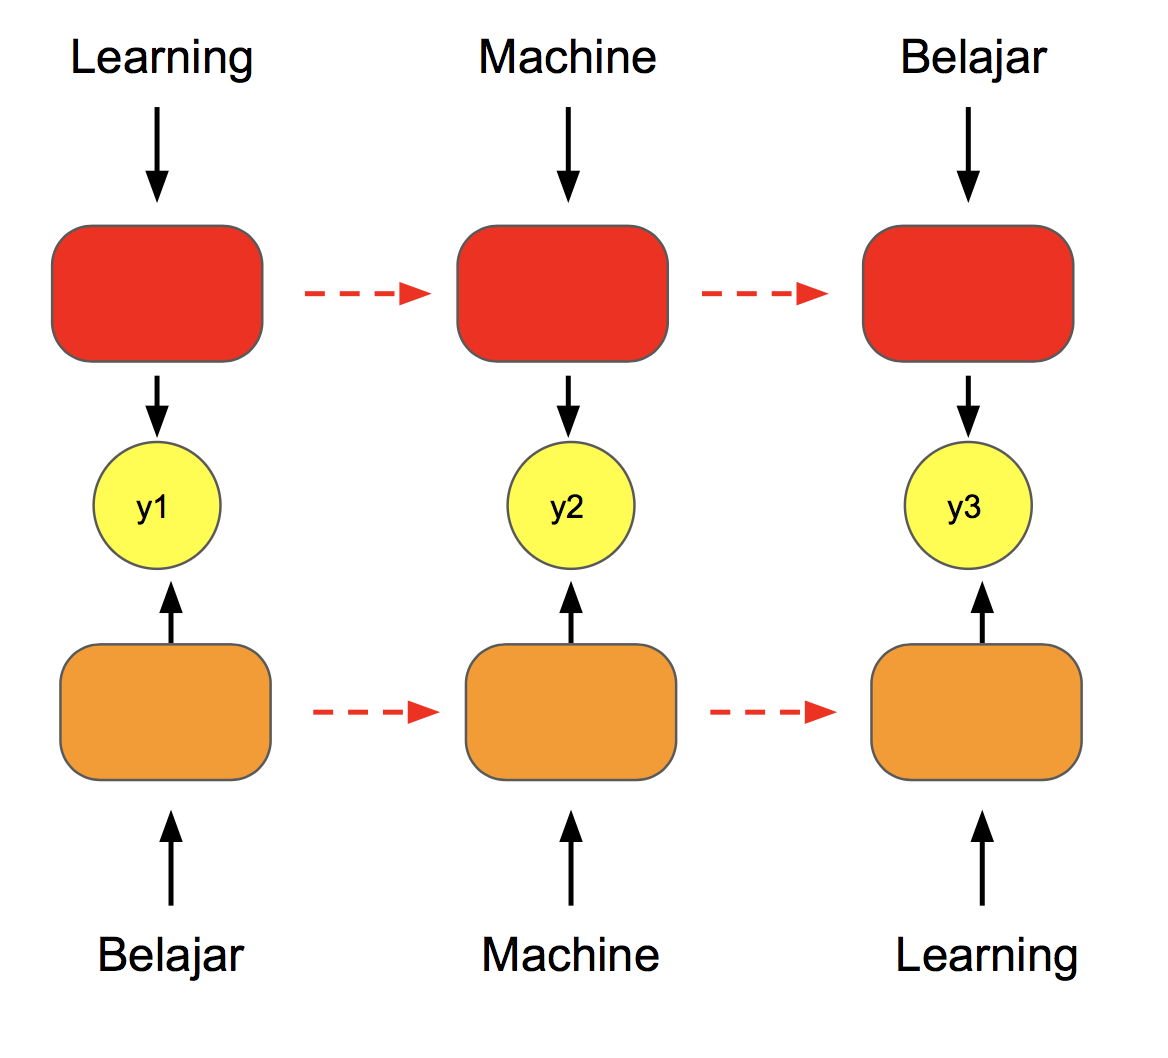

In [2]:
illustration.blstm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import data

In [4]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


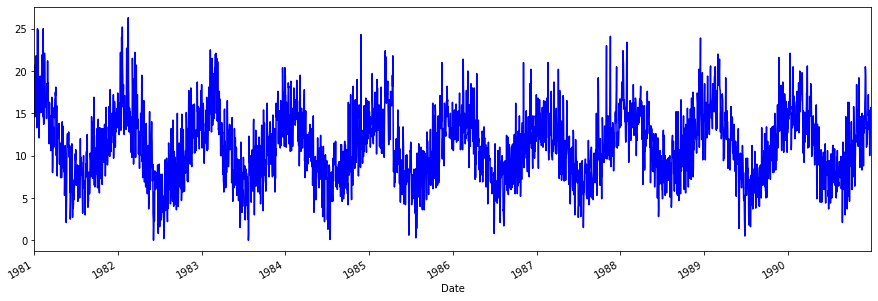

In [5]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape,ts_test.shape

((2920, 1), (730, 1))

## Dataset & Dataloader

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [8]:
bs = 32
seq_len = 14

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, num_workers=4)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



## Arsitektur & Config

In [9]:
class BILSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layer, dropout, batch_first=True):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layer, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [10]:
config = set_config({
    "input_size": 1,
    "output_size": 1,
    "seq_len": 14,
    "bs": 32,
    "hidden_size": 64,
    "num_layer": 2,
    "drop_out": 0
})

## Training Preparation => MCOC

In [11]:
model = BILSTM(config.input_size, config.output_size, config.hidden_size, config.num_layer, config.drop_out).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir="model/bilstm")

## Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 134.9839 | Test_cost  = 136.8084 | 




Epoch     2
Train_cost  = 123.7095 | Test_cost  = 122.6978 | 




Epoch     3
Train_cost  = 108.0874 | Test_cost  = 103.2752 | 




Epoch     4
Train_cost  = 88.3751 | Test_cost  = 82.7052 | 




Epoch     5
Train_cost  = 69.7887 | Test_cost  = 65.4452 | 




Epoch     6
Train_cost  = 54.6788 | Test_cost  = 51.6224 | 




Epoch     7
Train_cost  = 42.9697 | Test_cost  = 41.1852 | 




Epoch     8
Train_cost  = 34.4310 | Test_cost  = 33.7268 | 




Epoch     9
Train_cost  = 28.5161 | Test_cost  = 28.5334 | 




Epoch    10
Train_cost  = 24.4714 | Test_cost  = 24.9231 | 




Epoch    11
Train_cost  = 21.7632 | Test_cost  = 22.4981 | 




Epoch    12
Train_cost  = 19.9895 | Test_cost  = 20.8373 | 




Epoch    13
Train_cost  = 18.8175 | Test_cost  = 19.7098 | 




Epoch    14
Train_cost  = 18.0590 | Test_cost  = 18.9465 | 




Epoch    15
Train_cost  = 17.5704 | Test_cost  = 18.4249 | 




Epoch    16
Train_cost  = 17.2564 | Test_cost  = 18.0672 | 




Epoch    17
Train_cost  = 17.0551 | Test_cost  = 17.8199 | 




Epoch    18
Train_cost  = 16.9238 | Test_cost  = 17.6446 | 




Epoch    19
Train_cost  = 16.8331 | Test_cost  = 17.5148 | 




Epoch    20
Train_cost  = 16.7665 | Test_cost  = 17.4172 | 


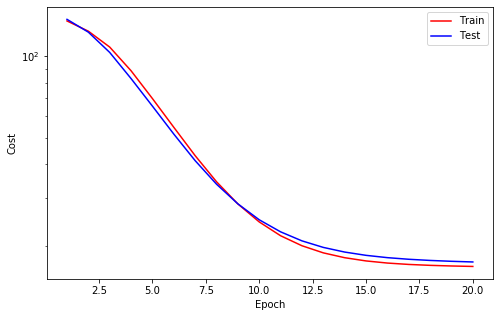



Epoch    21
Train_cost  = 16.7181 | Test_cost  = 17.3433 | 




Epoch    22
Train_cost  = 16.6788 | Test_cost  = 17.2790 | 




Epoch    23
Train_cost  = 16.6393 | Test_cost  = 17.2242 | 




Epoch    24
Train_cost  = 16.6010 | Test_cost  = 17.1716 | 




Epoch    25
Train_cost  = 16.5577 | Test_cost  = 17.1158 | 




Epoch    26
Train_cost  = 16.5086 | Test_cost  = 17.0628 | 




Epoch    27
Train_cost  = 16.4549 | Test_cost  = 17.0035 | 




Epoch    28
Train_cost  = 16.3877 | Test_cost  = 16.9282 | 




Epoch    29
Train_cost  = 16.2949 | Test_cost  = 16.8228 | 




Epoch    30
Train_cost  = 16.1568 | Test_cost  = 16.6637 | 




Epoch    31
Train_cost  = 15.9103 | Test_cost  = 16.3746 | 




Epoch    32
Train_cost  = 15.5045 | Test_cost  = 15.8637 | 




Epoch    33
Train_cost  = 14.9011 | Test_cost  = 15.2349 | 




Epoch    34
Train_cost  = 14.0041 | Test_cost  = 14.1828 | 




Epoch    35
Train_cost  = 13.1945 | Test_cost  = 13.4746 | 




Epoch    36
Train_cost  = 12.4482 | Test_cost  = 12.3924 | 




Epoch    37
Train_cost  = 11.3338 | Test_cost  = 11.1736 | 




Epoch    38
Train_cost  = 10.3559 | Test_cost  = 10.2565 | 




Epoch    39
Train_cost  = 9.5545 | Test_cost  = 9.4380 | 




Epoch    40
Train_cost  = 8.8917 | Test_cost  = 8.7771 | 


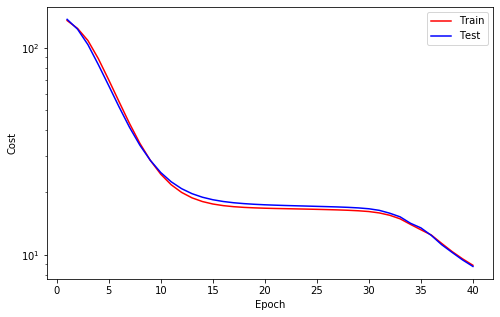



Epoch    41
Train_cost  = 8.3505 | Test_cost  = 8.1995 | 




Epoch    42
Train_cost  = 7.8928 | Test_cost  = 7.7171 | 




Epoch    43
Train_cost  = 7.5034 | Test_cost  = 7.2742 | 




Epoch    44
Train_cost  = 7.1491 | Test_cost  = 6.9141 | 




Epoch    45
Train_cost  = 6.8377 | Test_cost  = 6.5746 | 




Epoch    46
Train_cost  = 6.5548 | Test_cost  = 6.2877 | 




Epoch    47
Train_cost  = 6.2990 | Test_cost  = 6.0168 | 




Epoch    48
Train_cost  = 6.0569 | Test_cost  = 5.7781 | 




Epoch    49
Train_cost  = 5.8293 | Test_cost  = 5.5420 | 




Epoch    50
Train_cost  = 5.6155 | Test_cost  = 5.3240 | 




Epoch    51
Train_cost  = 5.4108 | Test_cost  = 5.1116 | 




Epoch    52
Train_cost  = 5.2085 | Test_cost  = 4.9194 | 




Epoch    53
Train_cost  = 5.0190 | Test_cost  = 4.7280 | 




Epoch    54
Train_cost  = 4.8360 | Test_cost  = 4.5402 | 




Epoch    55
Train_cost  = 4.6603 | Test_cost  = 4.3648 | 




Epoch    56
Train_cost  = 4.4944 | Test_cost  = 4.1987 | 




Epoch    57
Train_cost  = 4.3381 | Test_cost  = 4.0383 | 




Epoch    58
Train_cost  = 4.1896 | Test_cost  = 3.8841 | 




Epoch    59
Train_cost  = 4.0487 | Test_cost  = 3.7392 | 




Epoch    60
Train_cost  = 3.9147 | Test_cost  = 3.6005 | 


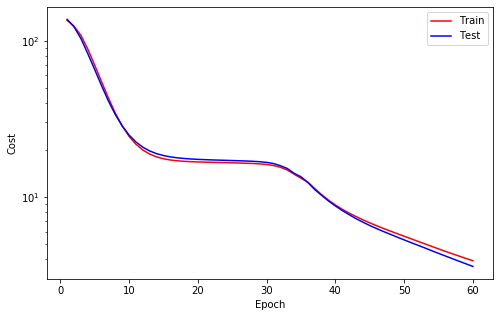



Epoch    61
Train_cost  = 3.7869 | Test_cost  = 3.4612 | 




Epoch    62
Train_cost  = 3.6631 | Test_cost  = 3.3237 | 




Epoch    63
Train_cost  = 3.5428 | Test_cost  = 3.1923 | 




Epoch    64
Train_cost  = 3.4255 | Test_cost  = 3.0657 | 




Epoch    65
Train_cost  = 3.3106 | Test_cost  = 2.9443 | 




Epoch    66
Train_cost  = 3.1990 | Test_cost  = 2.8265 | 




Epoch    67
Train_cost  = 3.0906 | Test_cost  = 2.7112 | 




Epoch    68
Train_cost  = 2.9848 | Test_cost  = 2.5978 | 




Epoch    69
Train_cost  = 2.8813 | Test_cost  = 2.4894 | 




Epoch    70
Train_cost  = 2.7810 | Test_cost  = 2.3860 | 




Epoch    71
Train_cost  = 2.6843 | Test_cost  = 2.2884 | 




Epoch    72
Train_cost  = 2.5916 | Test_cost  = 2.1939 | 




Epoch    73
Train_cost  = 2.5016 | Test_cost  = 2.1041 | 




Epoch    74
Train_cost  = 2.4150 | Test_cost  = 2.0158 | 




Epoch    75
Train_cost  = 2.3301 | Test_cost  = 1.9340 | 




Epoch    76
Train_cost  = 2.2505 | Test_cost  = 1.8533 | 




Epoch    77
Train_cost  = 2.1696 | Test_cost  = 1.7802 | 




Epoch    78
Train_cost  = 2.0972 | Test_cost  = 1.7034 | 




Epoch    79
Train_cost  = 2.0181 | Test_cost  = 1.6355 | 




Epoch    80
Train_cost  = 1.9527 | Test_cost  = 1.5634 | 


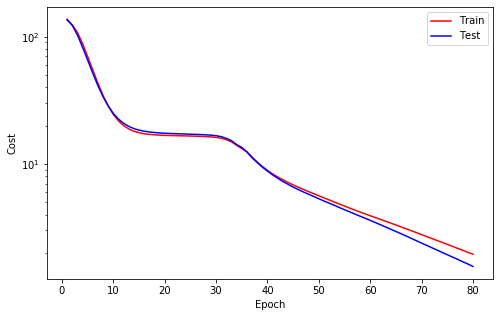



Epoch    81
Train_cost  = 1.8755 | Test_cost  = 1.4990 | 




Epoch    82
Train_cost  = 1.8152 | Test_cost  = 1.4348 | 




Epoch    83
Train_cost  = 1.7435 | Test_cost  = 1.3743 | 




Epoch    84
Train_cost  = 1.6872 | Test_cost  = 1.3181 | 




Epoch    85
Train_cost  = 1.6236 | Test_cost  = 1.2620 | 




Epoch    86
Train_cost  = 1.5714 | Test_cost  = 1.2117 | 




Epoch    87
Train_cost  = 1.5168 | Test_cost  = 1.1634 | 




Epoch    88
Train_cost  = 1.4712 | Test_cost  = 1.1182 | 




Epoch    89
Train_cost  = 1.4248 | Test_cost  = 1.0781 | 




Epoch    90
Train_cost  = 1.3852 | Test_cost  = 1.0391 | 




Epoch    91
Train_cost  = 1.3461 | Test_cost  = 1.0053 | 




Epoch    92
Train_cost  = 1.3117 | Test_cost  = 0.9719 | 




Epoch    93
Train_cost  = 1.2781 | Test_cost  = 0.9418 | 




Epoch    94
Train_cost  = 1.2474 | Test_cost  = 0.9130 | 




Epoch    95
Train_cost  = 1.2178 | Test_cost  = 0.8853 | 




Epoch    96
Train_cost  = 1.1895 | Test_cost  = 0.8601 | 




Epoch    97
Train_cost  = 1.1631 | Test_cost  = 0.8351 | 




Epoch    98
Train_cost  = 1.1376 | Test_cost  = 0.8127 | 




Epoch    99
Train_cost  = 1.1144 | Test_cost  = 0.7908 | 




Epoch   100
Train_cost  = 1.0917 | Test_cost  = 0.7702 | 


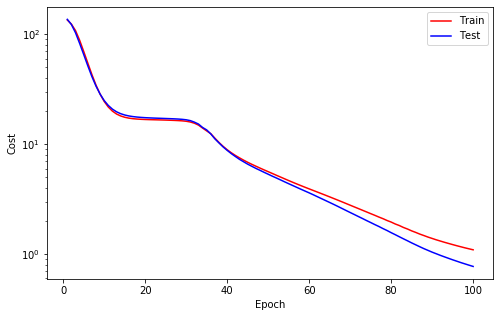



Epoch   101
Train_cost  = 1.0705 | Test_cost  = 0.7507 | 




Epoch   102
Train_cost  = 1.0500 | Test_cost  = 0.7320 | 




Epoch   103
Train_cost  = 1.0305 | Test_cost  = 0.7143 | 




Epoch   104
Train_cost  = 1.0117 | Test_cost  = 0.6974 | 




Epoch   105
Train_cost  = 0.9937 | Test_cost  = 0.6811 | 




Epoch   106
Train_cost  = 0.9763 | Test_cost  = 0.6658 | 




Epoch   107
Train_cost  = 0.9597 | Test_cost  = 0.6509 | 




Epoch   108
Train_cost  = 0.9436 | Test_cost  = 0.6369 | 




Epoch   109
Train_cost  = 0.9282 | Test_cost  = 0.6234 | 




Epoch   110
Train_cost  = 0.9133 | Test_cost  = 0.6106 | 




Epoch   111
Train_cost  = 0.8990 | Test_cost  = 0.5983 | 




Epoch   112
Train_cost  = 0.8852 | Test_cost  = 0.5865 | 




Epoch   113
Train_cost  = 0.8719 | Test_cost  = 0.5753 | 




Epoch   114
Train_cost  = 0.8592 | Test_cost  = 0.5646 | 




Epoch   115
Train_cost  = 0.8469 | Test_cost  = 0.5544 | 




Epoch   116
Train_cost  = 0.8350 | Test_cost  = 0.5446 | 




Epoch   117
Train_cost  = 0.8236 | Test_cost  = 0.5352 | 




Epoch   118
Train_cost  = 0.8125 | Test_cost  = 0.5263 | 




Epoch   119
Train_cost  = 0.8019 | Test_cost  = 0.5177 | 




Epoch   120
Train_cost  = 0.7916 | Test_cost  = 0.5095 | 


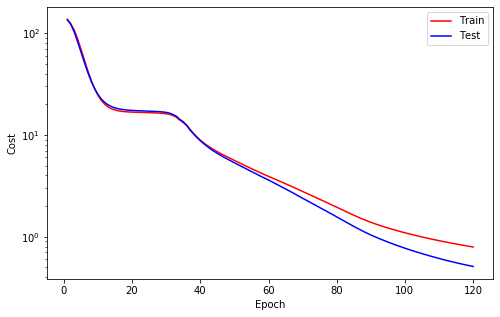



Epoch   121
Train_cost  = 0.7817 | Test_cost  = 0.5017 | 




Epoch   122
Train_cost  = 0.7721 | Test_cost  = 0.4941 | 




Epoch   123
Train_cost  = 0.7628 | Test_cost  = 0.4869 | 




Epoch   124
Train_cost  = 0.7538 | Test_cost  = 0.4800 | 




Epoch   125
Train_cost  = 0.7450 | Test_cost  = 0.4733 | 




Epoch   126
Train_cost  = 0.7366 | Test_cost  = 0.4669 | 




Epoch   127
Train_cost  = 0.7283 | Test_cost  = 0.4608 | 




Epoch   128
Train_cost  = 0.7204 | Test_cost  = 0.4549 | 




Epoch   129
Train_cost  = 0.7126 | Test_cost  = 0.4492 | 




Epoch   130
Train_cost  = 0.7051 | Test_cost  = 0.4438 | 




Epoch   131
Train_cost  = 0.6978 | Test_cost  = 0.4386 | 




Epoch   132
Train_cost  = 0.6907 | Test_cost  = 0.4336 | 




Epoch   133
Train_cost  = 0.6838 | Test_cost  = 0.4288 | 




Epoch   134
Train_cost  = 0.6771 | Test_cost  = 0.4243 | 




Epoch   135
Train_cost  = 0.6706 | Test_cost  = 0.4199 | 




Epoch   136
Train_cost  = 0.6643 | Test_cost  = 0.4158 | 




Epoch   137
Train_cost  = 0.6581 | Test_cost  = 0.4118 | 




Epoch   138
Train_cost  = 0.6521 | Test_cost  = 0.4081 | 




Epoch   139
Train_cost  = 0.6462 | Test_cost  = 0.4045 | 




Epoch   140
Train_cost  = 0.6405 | Test_cost  = 0.4012 | 


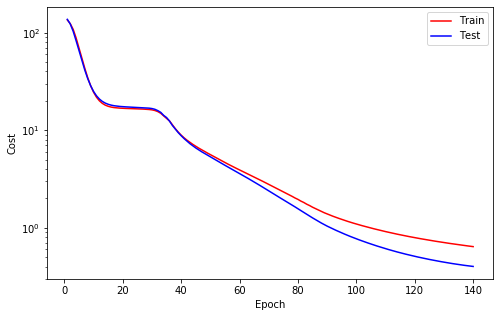



Epoch   141
Train_cost  = 0.6348 | Test_cost  = 0.3980 | 




Epoch   142
Train_cost  = 0.6293 | Test_cost  = 0.3951 | 




Epoch   143
Train_cost  = 0.6239 | Test_cost  = 0.3924 | 




Epoch   144
Train_cost  = 0.6186 | Test_cost  = 0.3901 | 




Epoch   145
Train_cost  = 0.6134 | Test_cost  = 0.3882 | 




Epoch   146
Train_cost  = 0.6087 | Test_cost  = 0.3870 | 




Epoch   147
Train_cost  = 0.6047 | Test_cost  = 0.3860 | 




Epoch   148
Train_cost  = 0.6015 | Test_cost  = 0.3842 | 




Epoch   149
Train_cost  = 0.5979 | Test_cost  = 0.3800 | 




Epoch   150
Train_cost  = 0.5926 | Test_cost  = 0.3736 | 




Epoch   151
Train_cost  = 0.5870 | Test_cost  = 0.3686 | 




Epoch   152
Train_cost  = 0.5831 | Test_cost  = 0.3655 | 




Epoch   153
Train_cost  = 0.5826 | Test_cost  = 0.3657 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3655




Epoch   154
Train_cost  = 0.5778 | Test_cost  = 0.3747 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3655




Epoch   155
Train_cost  = 0.5707 | Test_cost  = 0.3799 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3655




Epoch   156
Train_cost  = 0.5741 | Test_cost  = 0.3753 | 
==> EarlyStop patience =  4 | Best test_cost: 0.3655




Epoch   157
Train_cost  = 0.5757 | Test_cost  = 0.3604 | 




Epoch   158
Train_cost  = 0.5636 | Test_cost  = 0.3566 | 




Epoch   159
Train_cost  = 0.5549 | Test_cost  = 0.3579 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3566




Epoch   160
Train_cost  = 0.5524 | Test_cost  = 0.3675 | 


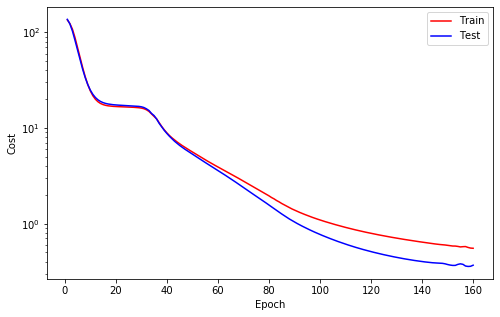

==> EarlyStop patience =  2 | Best test_cost: 0.3566




Epoch   161
Train_cost  = 0.5560 | Test_cost  = 0.3667 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3566




Epoch   162
Train_cost  = 0.5533 | Test_cost  = 0.3469 | 




Epoch   163
Train_cost  = 0.5400 | Test_cost  = 0.3506 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3469




Epoch   164
Train_cost  = 0.5339 | Test_cost  = 0.3620 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3469




Epoch   165
Train_cost  = 0.5415 | Test_cost  = 0.3554 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3469




Epoch   166
Train_cost  = 0.5379 | Test_cost  = 0.3418 | 




Epoch   167
Train_cost  = 0.5255 | Test_cost  = 0.3433 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3418




Epoch   168
Train_cost  = 0.5190 | Test_cost  = 0.3562 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3418




Epoch   169
Train_cost  = 0.5258 | Test_cost  = 0.3468 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3418




Epoch   170
Train_cost  = 0.5240 | Test_cost  = 0.3377 | 




Epoch   171
Train_cost  = 0.5131 | Test_cost  = 0.3389 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3377




Epoch   172
Train_cost  = 0.5072 | Test_cost  = 0.3512 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3377




Epoch   173
Train_cost  = 0.5131 | Test_cost  = 0.3418 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3377




Epoch   174
Train_cost  = 0.5131 | Test_cost  = 0.3349 | 




Epoch   175
Train_cost  = 0.5028 | Test_cost  = 0.3349 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3349




Epoch   176
Train_cost  = 0.4960 | Test_cost  = 0.3474 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3349




Epoch   177
Train_cost  = 0.5023 | Test_cost  = 0.3379 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3349




Epoch   178
Train_cost  = 0.5045 | Test_cost  = 0.3326 | 




Epoch   179
Train_cost  = 0.4938 | Test_cost  = 0.3313 | 




Epoch   180
Train_cost  = 0.4858 | Test_cost  = 0.3439 | 


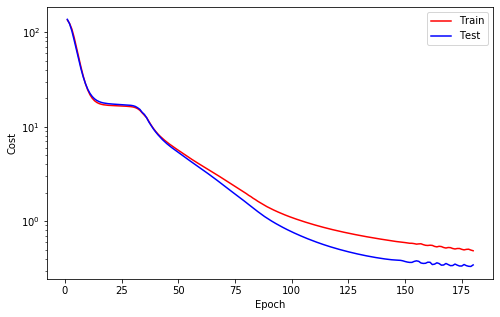

==> EarlyStop patience =  1 | Best test_cost: 0.3313




Epoch   181
Train_cost  = 0.4921 | Test_cost  = 0.3335 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3313




Epoch   182
Train_cost  = 0.4956 | Test_cost  = 0.3309 | 




Epoch   183
Train_cost  = 0.4849 | Test_cost  = 0.3288 | 




Epoch   184
Train_cost  = 0.4763 | Test_cost  = 0.3393 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3288




Epoch   185
Train_cost  = 0.4824 | Test_cost  = 0.3292 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3288




Epoch   186
Train_cost  = 0.4845 | Test_cost  = 0.3286 | 




Epoch   187
Train_cost  = 0.4747 | Test_cost  = 0.3271 | 




Epoch   188
Train_cost  = 0.4673 | Test_cost  = 0.3342 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3271




Epoch   189
Train_cost  = 0.4734 | Test_cost  = 0.3256 | 




Epoch   190
Train_cost  = 0.4718 | Test_cost  = 0.3259 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3256




Epoch   191
Train_cost  = 0.4631 | Test_cost  = 0.3263 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3256




Epoch   192
Train_cost  = 0.4590 | Test_cost  = 0.3282 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3256




Epoch   193
Train_cost  = 0.4644 | Test_cost  = 0.3230 | 




Epoch   194
Train_cost  = 0.4590 | Test_cost  = 0.3244 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3230




Epoch   195
Train_cost  = 0.4526 | Test_cost  = 0.3254 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3230




Epoch   196
Train_cost  = 0.4523 | Test_cost  = 0.3222 | 




Epoch   197
Train_cost  = 0.4554 | Test_cost  = 0.3209 | 




Epoch   198
Train_cost  = 0.4481 | Test_cost  = 0.3234 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3209




Epoch   199
Train_cost  = 0.4450 | Test_cost  = 0.3239 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3209




Epoch   200
Train_cost  = 0.4476 | Test_cost  = 0.3188 | 


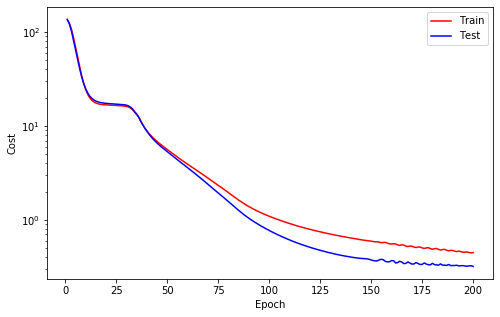



Epoch   201
Train_cost  = 0.4481 | Test_cost  = 0.3183 | 




Epoch   202
Train_cost  = 0.4397 | Test_cost  = 0.3213 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3183




Epoch   203
Train_cost  = 0.4381 | Test_cost  = 0.3234 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3183




Epoch   204
Train_cost  = 0.4429 | Test_cost  = 0.3190 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3183




Epoch   205
Train_cost  = 0.4415 | Test_cost  = 0.3150 | 




Epoch   206
Train_cost  = 0.4328 | Test_cost  = 0.3181 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3150




Epoch   207
Train_cost  = 0.4291 | Test_cost  = 0.3237 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3150




Epoch   208
Train_cost  = 0.4341 | Test_cost  = 0.3190 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3150




Epoch   209
Train_cost  = 0.4340 | Test_cost  = 0.3108 | 




Epoch   210
Train_cost  = 0.4265 | Test_cost  = 0.3154 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3108




Epoch   211
Train_cost  = 0.4198 | Test_cost  = 0.3215 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3108




Epoch   212
Train_cost  = 0.4233 | Test_cost  = 0.3173 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3108




Epoch   213
Train_cost  = 0.4257 | Test_cost  = 0.3118 | 
==> EarlyStop patience =  4 | Best test_cost: 0.3108




Epoch   214
Train_cost  = 0.4207 | Test_cost  = 0.3142 | 
==> EarlyStop patience =  5 | Best test_cost: 0.3108
==> Execute Early Stopping at epoch: 214 | Best test_cost: 0.3108
==> Best model is saved at model/bilstm


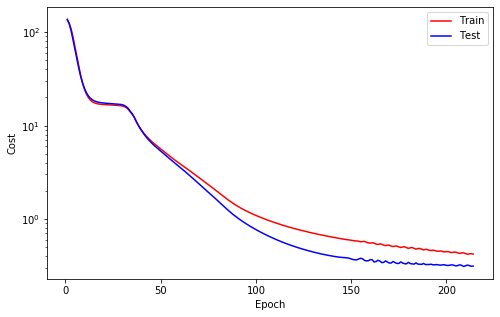

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [14]:
from luwiji.rnn import illustration

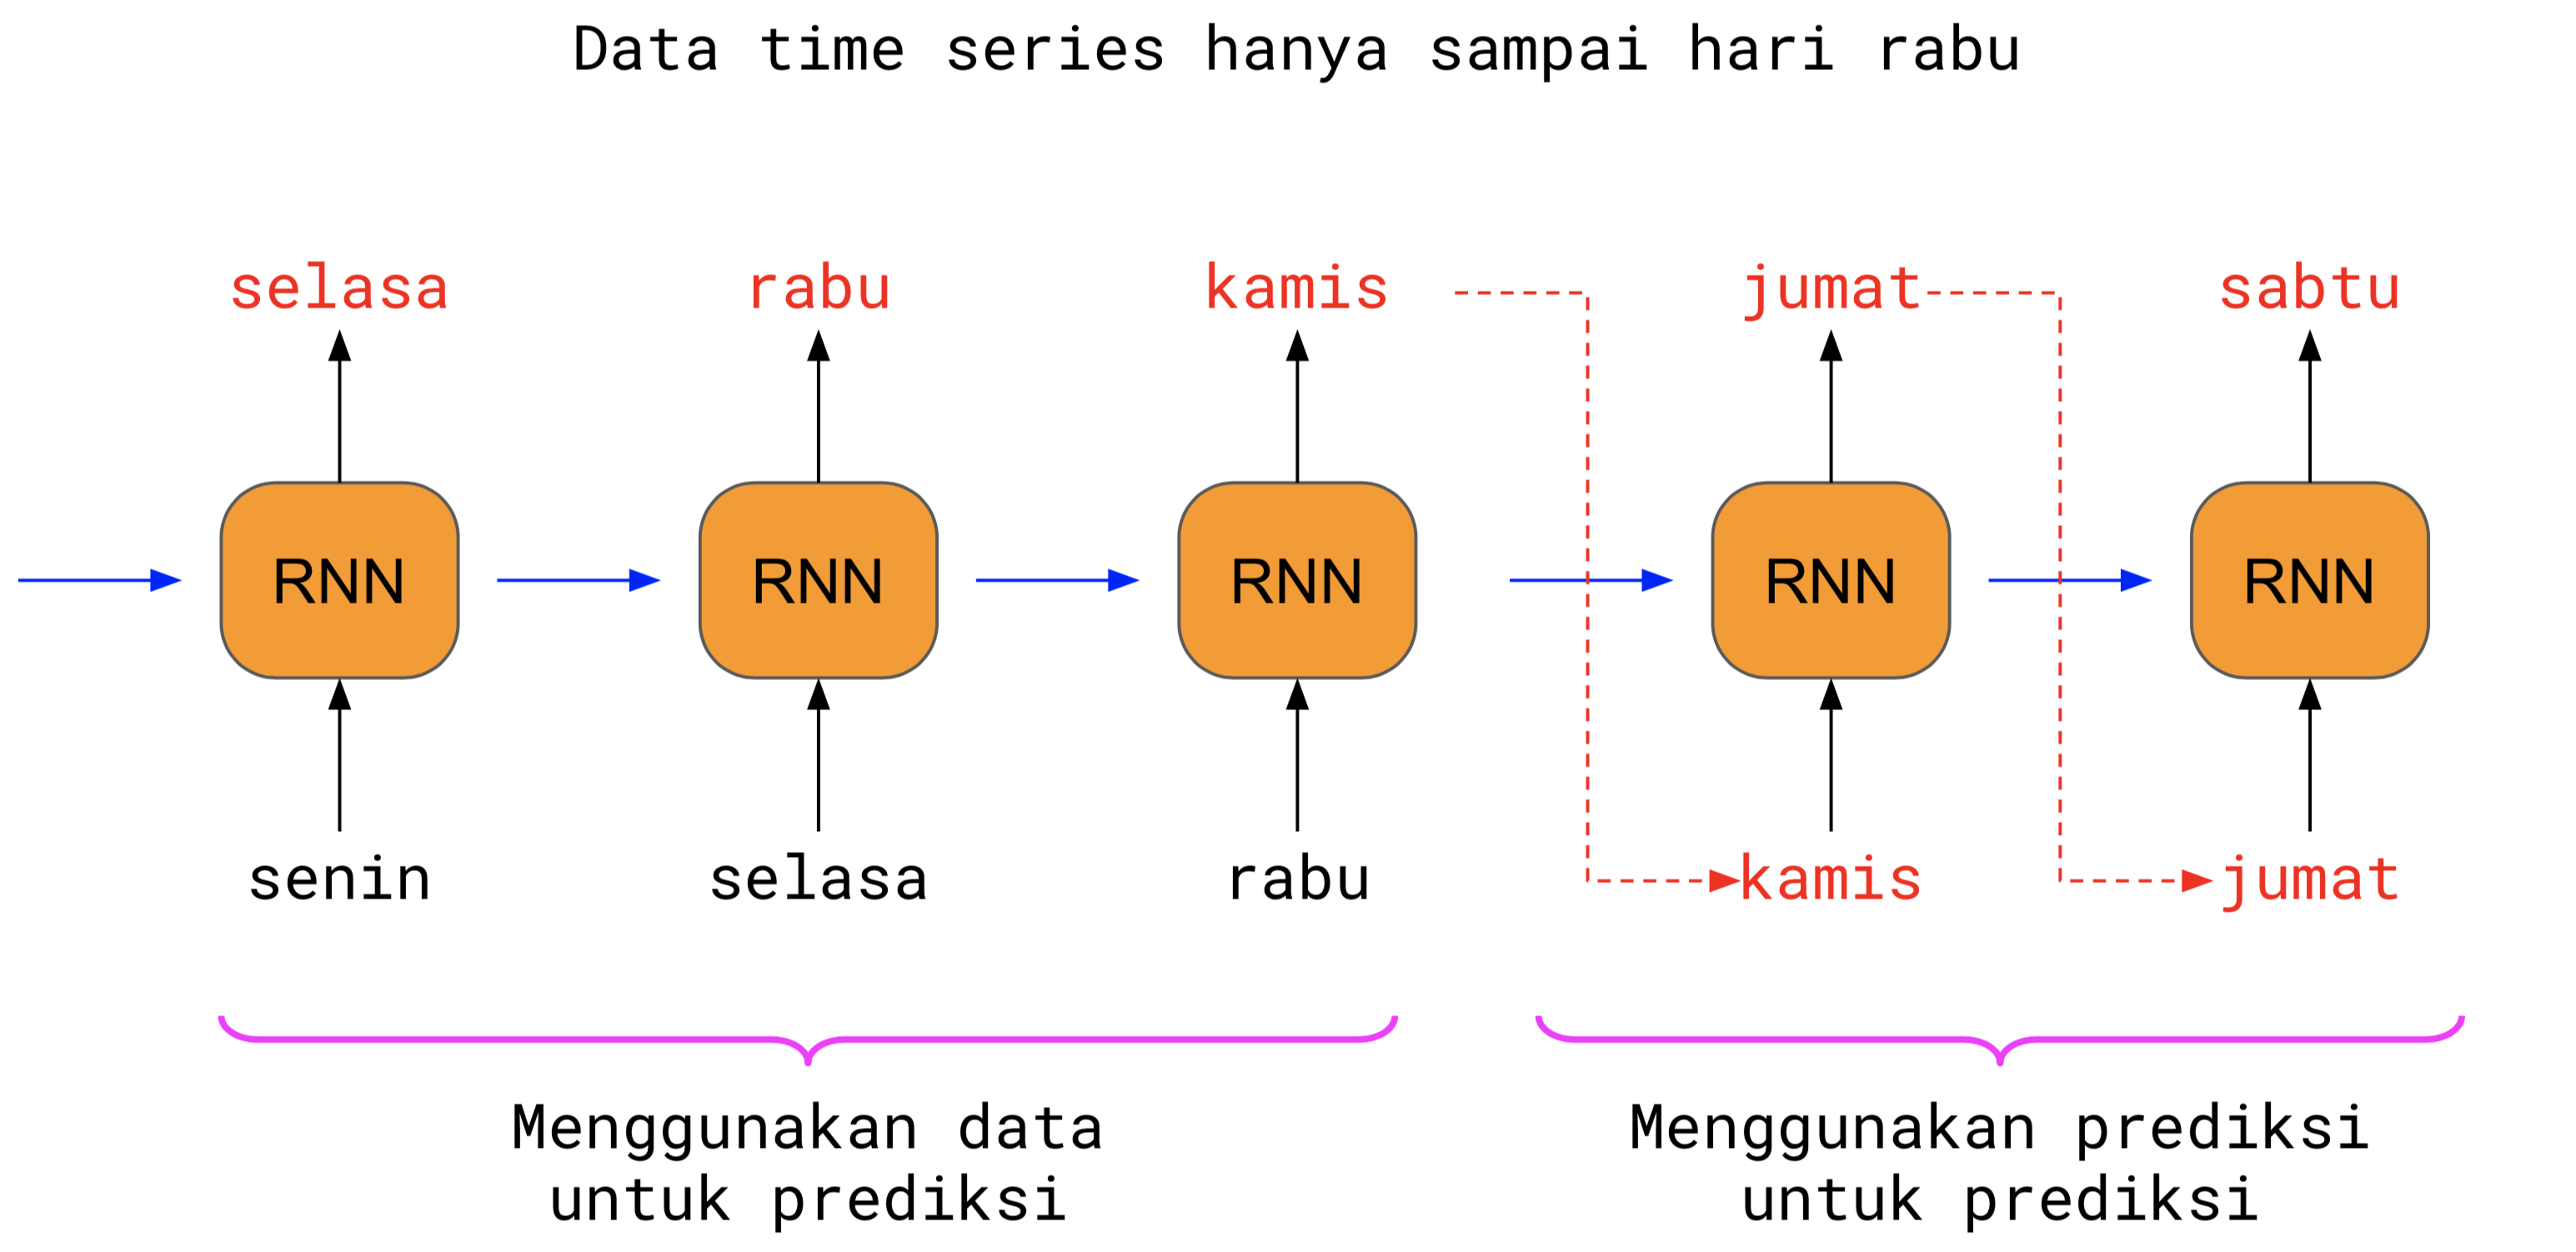

In [15]:
illustration.forecast

In [16]:
from utils import data4pred, pred4pred

In [17]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

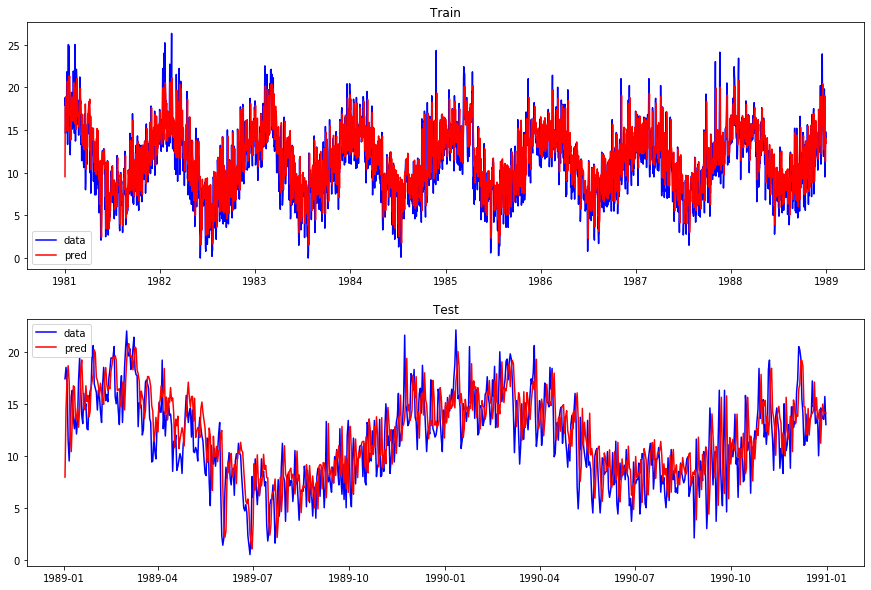

In [18]:
# Data for Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

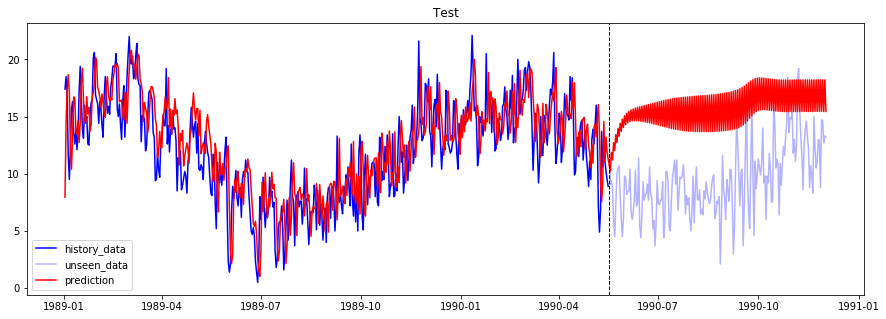

In [22]:
# Pred for Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")